In [8]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from neural_exploration import *
import pandas as pd
sns.set()

## Read the dataset

In [3]:
articles_file = "./data/webscope-articles.txt"
log_file = "/home/jupyter/neural_exploration/data/webscope-logs.txt"
articles_np = np.loadtxt(articles_file)
articles = {}
for art in articles_np:
    articles[int(art[0])] = [float(x) for x in art[1:]]


### Bandit settings

In [4]:
T = int(100000)
n_arms = 80
n_features = 12
noise_std = 0.1

confidence_scaling_factor = noise_std

n_sim = 2

SEED = 42
np.random.seed(SEED)

### Neural network settings

In [5]:
p = 0.2
hidden_size = 64
epochs = 100
train_every = 10
confidence_scaling_factor = 1.0
use_cuda = False

### NeuralUCB on linear rewards

In [6]:
### mean reward function
a = np.random.randn(n_features)
a /= np.linalg.norm(a, ord=2)
h = lambda x: 10*np.dot(a, x)
bandit = ContextualBandit(T, n_arms, n_features, noise_std=noise_std, seed=SEED, articles=articles, log_file=log_file)


In [9]:

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
        
    model.run()
    regrets[i] = np.cumsum(model.regrets)

100%|██████████| 100000/100000 [2:39:52<00:00, 10.42it/s, total regret=1.02e+5, % optimal arm=1.23%, ctr=3.1553%, i=1236, score=39]


### Sublinear regret growth : the bandit problem is solved efficiently

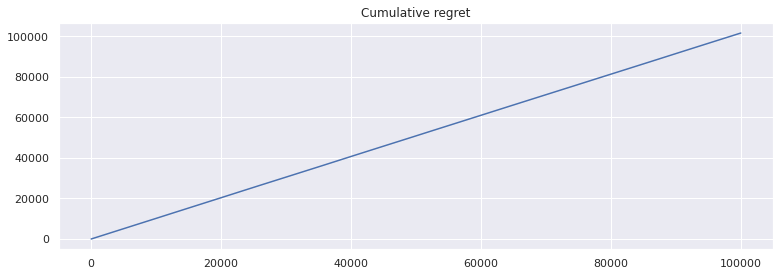

In [10]:
fig, ax = plt.subplots(figsize=(11, 4), nrows=1, ncols=1)

t = np.arange(T)

mean_regrets = np.mean(regrets, axis=0)
std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
ax.plot(t, mean_regrets)
ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
    
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig.savefig('figures/neural_ucb_linear.pdf')